In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
# parameters
J = 1
kB = 1
Tc = 2/np.log(1+np.sqrt(2))
Kc = np.log(1+np.sqrt(2))/2

## Exact solution for 2x2 lattice

In [ ]:
#  exact solution for 2 by 2 lattice
def exact(T):
    beta = 1 / (kB*T)
    Z = 2*np.exp(8*beta)+12+2*np.exp(-8*beta)
    F = -np.log(Z)/beta
    E = -(2*8*np.exp(8*beta)+2*(-8)*np.exp(-8*beta))/Z
    E_sqr = (2*64*np.exp(8*beta) +2*64*np.exp(-8*beta))/Z
    C = (E_sqr-E*E)*(beta*beta)
    M_abs = (2*4*np.exp(8*beta)+8*2)/Z
    M_sqr = (2*16*np.exp(8*beta)+8*4)/Z
    chi_p = (M_sqr-M_abs*M_abs)*beta
    
    return Z, E

## Bare tensors

In [ ]:
#==================================================================#
##
##       3          3       
##     2--(TO)--0     2--(T1)--0
##       1          1  
##
##       3          3 
##     2--(T3)--0     2--(T2)--0
##       1          1 
#==================================================================#

## Contraction on a 2x2 lattice

Construct bare tensors $T$ and $T_z$ for the 2D Ising model.

Perform exact contract on a 2x2 lattice to obtain
* Partition function $Z$.
* Energy per bond. (via <S(0,0) S(0,1)>).
* Correlation at maximal distance <S(0,0> S(1,1)>.

Compare to the exact results on a 2x2 lattice.

In [ ]:
def W_matrix(T):
    return np.array([[np.sqrt(np.cosh(1/T)), np.sqrt(np.sinh(1/T))],
                     [np.sqrt(np.cosh(1/T)), -np.sqrt(np.sinh(1/T))]])

def eval_TM_Tz(T):
    W = W_matrix(T)
    TM = np.zeros((2,2,2,2))
    Tz = np.zeros((2,2,2,2))
    for a in range(2):
        for i in range(2):
            for j in range(2):
                for k in range(2):
                    for l in range(2):
                        TM[i, j, k, l] += W[a, i] * W[a, j] * W[a, k] * W[a, l]
                        Tz[i, j, k, l] += W[a, i] * W[a, j] * W[a, k] * W[a, l] * (-1)**a
    return TM, Tz

In [ ]:
#==================================================================#
##
##       3          3       
##     2--(TO)--0     2--(T1)--0
##       1          1  
##
##       3          3 
##     2--(T3)--0     2--(T2)--0
##       1          1 
#==================================================================#

In [ ]:
#==================================================================#
##
##       |          |       
##     1--(TO --0     1--(T1 --0
#      3--T3)--2      3--T2)--2
##       |          |  
##
#==================================================================#

In [ ]:
def contraction_2x2 (T0, T1, T2, T3):
    T0T3 = np.tensordot(T0, T3, ([1,3],[3,1]))
    T1T2 = np.tensordot(T1, T2, ([1,3],[3,1]))
    T0123 = np.tensordot(T0T3, T1T2, ([0,1,2,3],[1,0,3,2]))
    return T0123

In [ ]:
def eval_td(T_min, T_max, exported_file_name):
    T_array = np.linspace(T_min, T_max, 1000)
    n = m = 2
    number_of_bonds = 2*4
    lnZ_over_mn_array = np.zeros_like(T_array)
    E_td_over_mn_array = np.zeros_like(T_array)
    C_td_over_mn_array = np.zeros_like(T_array)
        
    for j in range(len(T_array)):
        T = T_array[j]
        TM, Tz = eval_TM_Tz(T)
        # Z_td[i] = contraction_2x2 (TM, TM, TM, TM)
        lnZ_over_mn_array[j] = np.log(contraction_2x2 (TM, TM, TM, TM)) / (m * n)
        E_td_over_mn_array[j] = -J * contraction_2x2 (Tz, Tz, TM, TM) / contraction_2x2 (TM, TM, TM, TM) * number_of_bonds / (m*n)
    data = pd.DataFrame({'T'       : T_array,
              'lnZ_over_mn'  : lnZ_over_mn_array,
              'E_td_over_mn' : E_td_over_mn_array})
    data.to_csv('%s (m = %.d).csv' %(exported_file_name, m))

In [ ]:
eval_td(T_min=1, T_max=4, exported_file_name = 'tensordot_data_1')

Correlation at maximal distance <S(0,0> S(1,1)>

Text(0, 0.5, '<S(0,0)S(1,1)>')

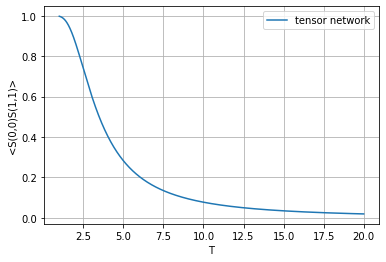

In [ ]:
T = np.linspace(1, 20, 1000)

S00S11 = np.zeros_like(T)

for i in range(len(T)):
    TM, Tz = eval_TM_Tz(T[i])
    S00S11[i] = contraction_2x2 (Tz, TM, Tz, TM) / contraction_2x2 (TM, TM, TM, TM)

plt.plot(T, S00S11, label =('tensor network'))
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('T')
plt.ylabel('<S(0,0)S(1,1)>')

## Contraction on a 4x4 lattice

* Contract vertical first:

In [ ]:
#==============================================================================================================================#
##          3              2                5'
##     2--(T0)--0      1--(T0--0      4'--(T0--0'                  
##          1              |                |                         3(D2)
##               -->       |      -->       |        -->      2(D4)--(T0T3)--0(D4)
##          3              |                |                         1(D2)
##     2--(T3)--0      5--T3)--3       3'--T3)--1'                  
##          1              4                2'
#==============================================================================================================================#

In [ ]:
def contraction_vertical(T0, T3):
    T0T3 = np.tensordot(T0, T3, ([1,3]))
    # (0,3,4,5,1,2) --> (0',1',2',3',4',5')
    T0T3_transpose = np.transpose(T0T3, (0,3,4,5,1,2))
    T0T3_reshape   = np.reshape(T0T3_transpose, (4, 2, 4, 2))
    return T0T3_reshape

In [ ]:
#==============================================================================================================================#
##
##           3              3                     2   5                     4'  5'                        3(D4)
##     2--(T0T3)--0    2--(T1T2)--0    -->    1--(T0123)--3    -->     3'--(T0123)--0'    -->     2(D4)--(T0123)--0(D4)
##           1              1                     0   4                     2'  1'                        1(D4)
##
#==============================================================================================================================#

In [ ]:
def contraction_4x4_vertical(T0, T1, T2, T3):
    T0T3  = contraction_vertical(T0, T3)
    T1T2  = contraction_vertical(T1, T2)
    T0123 = np.tensordot(T0T3, T1T2, ([0,2]))
    # (3,4,0,1,2,5) --> (0',1',2',3',4',5')
    T0123_transpose = np.transpose(T0123, (3,4,0,1,2,5))
    T0123_reshape   = np.reshape(T0123_transpose, (4, 4, 4, 4))
    return T0123_reshape

* Contract horizontal first

In [ ]:
#==============================================================================================================================#
##
##          3             3                   2  5                     4' 5'                        3(D4)
##     2--(T0)--0    2--(T1)--0    -->    1--(T0T1)--3    -->     3'--(T0T1)--0'    -->     2(D2)--(T0T1)--0(D2)
##          1             1                   0  4                     2' 1'                        1(D4)
##
#==============================================================================================================================#

In [ ]:
def contraction_horizontal(T0, T1):
    T0T1 = np.tensordot(T0, T1, ([0,2]))
    # (3,4,0,1,2,5) --> (0',1',2',3',4',5')
    T0T1_transpose = np.transpose(T0T1, (3,4,0,1,2,5))
    T0T1_reshape   = np.reshape(T0T1_transpose, (2, 4, 2, 4))
    return T0T1_reshape

In [ ]:
#==============================================================================================================================#
##           3                    2                      5'
##     2--(T0T1)--0          1--(T0T1--0           4'--(T0T1--0'                  
##           1                    |                      |                         3(D4)
##                     -->        |        -->           |        -->      2(D4)--(T0123)--0(D4)
##           3                    |                      |                         1(D4)
##     2--(T3T2)--0          5--T3T2)--3           3'--T3T2)--1'                  
##           1                    4                      2'
#==============================================================================================================================#

In [ ]:
def contraction_4x4_horizontal(T0, T1, T2, T3):
    T0T1  = contraction_horizontal(T0, T1)
    T3T2  = contraction_horizontal(T3, T2)
    T0123 = np.tensordot(T0T1, T3T2, ([1,3]))
    # (0,3,4,5,1,2) --> (0',1',2',3',4',5')
    T0123_transpose = np.transpose(T0123, (0,3,4,5,1,2))
    T0123_reshape  = np.reshape(T0123_transpose, (4, 4, 4, 4))
    return T0123_reshape

In [ ]:
T = 3
TM, Tz = eval_TM_Tz(T)
TM_tilde_1 = contraction_4x4_vertical(TM, TM, TM, TM)
print(len(TM_tilde_1))

4


Text(0, 0.5, '<S(0,0)S(2,2)>')

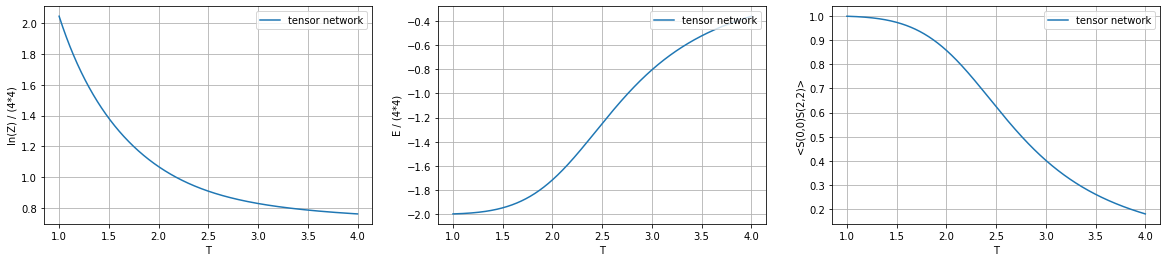

In [ ]:
T = np.linspace(1, 4, 1000)

Z_tn = np.zeros_like(T)
E_per_bond_tn = np.zeros_like(T)
S00S22 = np.zeros_like(T)

for i in range(len(T)):
    TM, Tz = eval_TM_Tz(T[i])
    TM_tilde = contraction_4x4_vertical(TM, TM, TM, TM)
    Tz_1  = contraction_4x4_vertical(Tz, Tz, TM, TM)
    Tz_2  = contraction_4x4_vertical(Tz, TM, TM, TM)
    Z_tn[i]  = contraction_2x2 (TM_tilde, TM_tilde, TM_tilde, TM_tilde)
    E_per_bond_tn[i] = -J * contraction_2x2 (Tz_1, TM_tilde, TM_tilde, TM_tilde) / Z_tn[i]
    S00S22[i] = contraction_2x2 (Tz_2, TM_tilde, Tz_2, TM_tilde) / Z_tn[i]
    E_tn = E_per_bond_tn * (2**(4+1))
    
#for i in range(len(T)):
    #TM, Tz = eval_TM_Tz(T[i])
    #Z_tn[i] = contraction_2x2 (TM, TM, TM, TM)
    #E_per_bond_tn[i] = -J * contraction_2x2 (Tz, Tz, TM, TM) / Z_tn[i]
    #Z_exact[i], E_exact[i] = exact(T[i])
    #E_per_bond_exact = E_exact / 8

plt.figure(figsize=(20, 4))
plt.subplot(1, 3, 1)    
plt.plot(T, np.log(Z_tn)/(4*4), label =('tensor network'))
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('T')
plt.ylabel('ln(Z) / (4*4)')

plt.subplot(1, 3, 2)    
plt.plot(T, E_tn/(4*4), label =('tensor network'))
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('T')
plt.ylabel('E / (4*4)')

plt.subplot(1, 3, 3)    
plt.plot(T, S00S22, label =('tensor network'))
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('T')
plt.ylabel('<S(0,0)S(2,2)>')

In [ ]:
def eval_td_4x4(T_min, T_max, exported_file_name):
    T_array = np.linspace(T_min, T_max, 1000)
    n = m = 4
    number_of_bonds = 2*m*n
    lnZ_over_mn_array = np.zeros_like(T_array)
    E_td_over_mn_array = np.zeros_like(T_array)
    C_td_over_mn_array = np.zeros_like(T_array)
    TM_4x4_max_array = np.zeros_like(T_array)
    Tz_4x4_max_array = np.zeros_like(T_array)
    for j in range(len(T_array)):
        T = T_array[j]
        # first contraction
        TM, Tz = eval_TM_Tz(T)
        # ruduce the values of TM and Tz
        M1  = np.max(np.max(TM), np.max(Tz))
        TM1 = TM / M1
        Tz1 = Tz / M1
        # second contraction
        TM_tilde = contraction_4x4_vertical(TM1, TM1, TM1, TM1)
        Tz_tilde = contraction_4x4_vertical(Tz1, Tz1, TM1, TM1)
        # ruduce the values of TM_tilde and Tz_tilde
        M2  = np.max(np.max(TM_tilde), np.max(Tz_tilde))
        TM2 = TM_tilde / M2
        Tz2 = Tz_tilde / M2
        # trace outside
        # Z = contraction_2x2(TM2, TM2, TM2, TM2) * (M1)**(m*n) * (M2)**(np.sqrt((m*n))
        lnZ_over_mn_array[j]  = 1/(m*n) * np.log(contraction_2x2(TM2, TM2, TM2, TM2)) + np.log(M1) + 1/np.sqrt(m*n) * np.log(M2)
        E_td_over_mn_array[j] = -J * contraction_2x2 (Tz2, Tz2, TM2, TM2) / contraction_2x2(TM2, TM2, TM2, TM2) * number_of_bonds / (m*n)
    data = pd.DataFrame({'T'       : T_array,
                        'lnZ_over_mn'  : lnZ_over_mn_array,
                        'E_td_over_mn' : E_td_over_mn_array})
    data.to_csv('%s (m = %.d).csv' %(exported_file_name, m))